*Ising Model Approach*

In [13]:
import numpy as np
import torch
from collections import Counter
collect_states_ising = Counter()


Matrix of weights and vector of biases.

In [14]:
matrix = [
    [0, -1, 2],
    [-1, 0, 2],
    [2, 2, 0]
]

weights = torch.tensor(matrix, dtype=torch.float32)
bias = torch.tensor([1, 1, -2], dtype=torch.float32)

In [15]:

def from_torch_to_numpy(tensor: torch.Tensor):
    return tensor.detach().cpu().numpy()

Implementation of the energy formula using numpy library.   

In [16]:
def energy_function(p_bits: torch.Tensor, weights: torch.Tensor, bias: torch.Tensor):
    return -np.sum(np.multiply(from_torch_to_numpy(weights), from_torch_to_numpy(torch.outer(p_bits, p_bits)))) - torch.dot(p_bits, bias)

In [17]:
def activation_function(syn_input: torch.Tensor, beta: float):
    return torch.sign(torch.tanh(beta * (-syn_input)) - (torch.rand(1) * 2 - 1))

In [19]:
def calculate_gradient(p_bits: torch.Tensor, weights: torch.Tensor, bias: torch.Tensor):
    energy = energy_function(p_bits, weights, bias)
    energy.backward(torch.ones(energy.shape))
    p_bits.retain_grad()
    return p_bits.grad

In [20]:
def evaluate(initial_beta, weights: torch.Tensor, bias: torch.Tensor, n: int):
    p_bits = torch.ones(n, requires_grad=True)
    prev_energy = energy_function(p_bits, weights, bias)
    beta = initial_beta
    ans = torch.ones(n, requires_grad=True)        
    for i in range(1000):
        indices = torch.randperm(n - 1) # n-th output is clamped
        for index, value in enumerate(indices):
            new_beta = beta + 0.1
            iteration = n * i + index
            new_p_bits = p_bits 
            gradient = calculate_gradient(new_p_bits, weights, bias)
            syn_input = gradient[value]
            with torch.no_grad():
                new_p_bits[value] = activation_function(syn_input, new_beta)
            new_energy = energy_function(new_p_bits, weights, bias)
            
            if new_energy < prev_energy: 
                beta = new_beta
                prev_energy = new_energy
                ans = new_p_bits.clone()
            p_bits = new_p_bits
    print(ans.tolist())

In [21]:
seed = 42
torch.manual_seed(seed)
n = 3

evaluate(initial_beta=0.25, weights=weights, bias=bias, n=n)

[1.0, 1.0, 1.0]


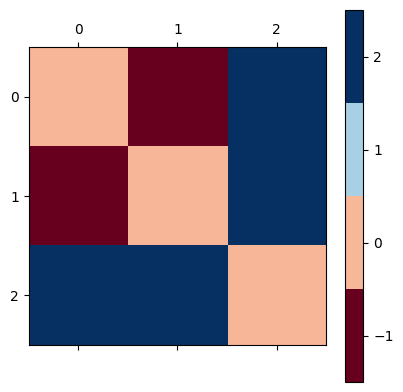

In [22]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.get_cmap('RdBu', np.max(matrix) - np.min(matrix) + 1)
mat = plt.matshow(matrix, cmap=cmap, vmin=np.min(matrix) - 0.5, vmax=np.max(matrix) + 0.5)
cax = plt.colorbar(mat, ticks=np.arange(np.min(matrix), np.max(matrix) + 1))